In [41]:
from matplotlib import pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import os
import random
import numpy as np

In [42]:
!unzip yalefaces.zip

Archive:  yalefaces.zip
replace yalefaces/person-4/rightlight? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [43]:
BASE_DIR = "yalefaces"
folders = [
    "person-1",
    "person-2",
    "person-4",
    "person-5",
    "person-7",
    "person-8",
    "person-10",
    "person-11",
    "person-12",
    "person-13",
    "person-14",
    "person-15"
]

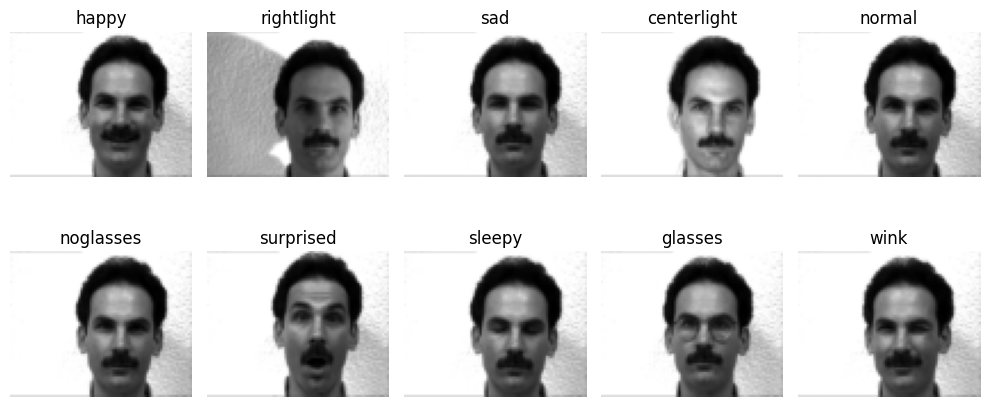

In [44]:
person_folder = random.choice(folders)
plt.figure(figsize=(10, 5))  # width, height in inches

for i, filename in enumerate(os.listdir(os.path.join(BASE_DIR, person_folder))):
    try:
        image = imread(os.path.join(BASE_DIR, person_folder, filename))
        image = image.squeeze(0)
        image = resize(image, (64, 80), anti_aliasing=True)

        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title(filename)

    except Exception as e:
        print(f"Lỗi khi xử lý file {filename}: {e}")

plt.tight_layout()
plt.show()

In [45]:
data = {}
for folder in folders:
  for filename in os.listdir(os.path.join(BASE_DIR, folder)):
    image = imread(os.path.join(BASE_DIR, folder, filename))
    image = resize(image, (1,64, 80), anti_aliasing=True)
    if folder not in data:
      data[folder] = [image]
    else:
      data[folder] .append(image)

for sample in data:
  data[sample] = np.concat(data[sample], axis = 0).reshape(10, -1)

In [46]:
def standardizing(images):
  images = (images - images.mean()) / images.std()
  images = images.astype(np.float32)

  return images

## Assignment 1 (4 scores): Implement PCA using Numpy.

In [47]:
from re import X
class PCA:
  def __init__(self, d_principle: int = 1):
    self.d_principle = d_principle
  def fit(self, X):
    cov = (X.T @ X)

    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
    signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
    eigenvectors = eigenvectors * signs[np.newaxis,:]
    eigenvectors = eigenvectors.T

    eigen_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i,:]) for i in range(len(eigenvalues))]

    eigen_pairs.sort(key = lambda pair: pair[0], reverse = True)

    eigenvalues = np.array([value for (value,_) in eigen_pairs])
    eigenvectors = np.array([vector for (_,vector) in eigen_pairs])

    self.principle_values = eigenvalues[:self.d_principle]
    self._W = eigenvectors[:self.d_principle]

  def transform(self, X):
     X_hat = self._W @ X
     return X_hat

In [48]:
model = PCA(d_principle=20)

In [49]:
images = []
for person in data:
  images.append(data[person])
images = np.concat(images, axis = 0)
images = standardizing(images)
images.shape

(120, 5120)

In [50]:
model.fit(images)

In [51]:
model._W.shape

(20, 5120)

## Assignment 2 (4 scores):
- Reading the training images.
- Approximating the Principle Space having **20 dimensions**.
- Visualize the base of this Principle Space.

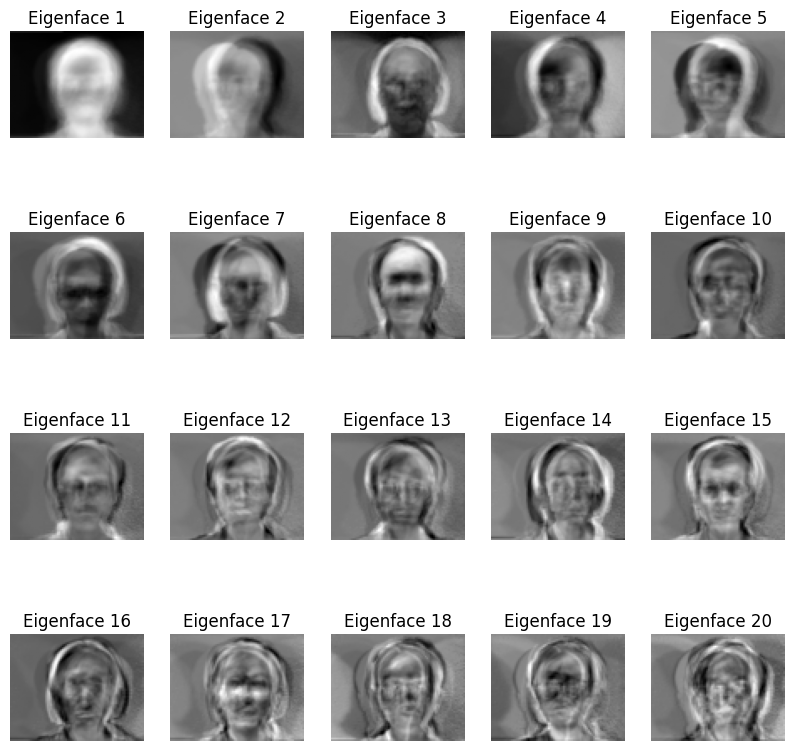

In [52]:
eigenfaces = model._W
eigenfaces = eigenfaces.reshape(20, 64, 80)
plt.figure(figsize=(10,10))
for ith, eigenface in enumerate(eigenfaces):
  plt.subplot(4,5,ith+1)
  plt.imshow(eigenface, cmap='gray')
  plt.axis('off')
  plt.title(f'Eigenface {ith+1}')
plt.show()

In [53]:
mean_faces = {
    person: np.mean(data[person], axis=0)
    for person in data
}

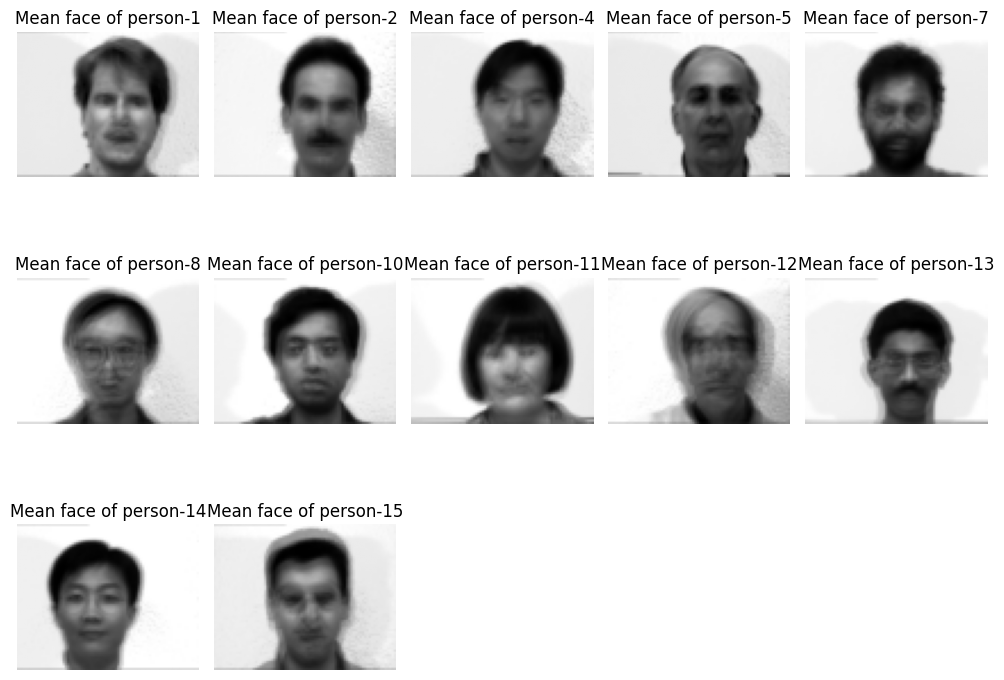

In [54]:
plt.figure(figsize=(10,10))
for ith, person in enumerate(mean_faces):
  plt.subplot(4,5,ith+1)
  plt.imshow(mean_faces[person].reshape(64, 80), cmap='gray')
  plt.axis('off')
  plt.title(f'Mean face of {person}')
plt.tight_layout()
plt.show()

In [55]:
projected_mean_faces = {}
for person in mean_faces:
  mean_face = mean_faces[person]
  projected_mean_faces[person] = model.transform(mean_face)

## Assignment 3 (2 scores):
- Assign persons to the face images in testing data.
- Evaluate the accuracy of this face recognition system.

In [56]:
labels = []
test_images = []
TEST_DIR = "yalefaces/test"
for filename in os.listdir(os.path.join(TEST_DIR)):
  person_name = filename.split(".")[0]
  labels.append(person_name)

  image = imread(os.path.join(TEST_DIR, filename))
  image = resize(image, (1,64, 80), anti_aliasing=True)
  test_images.append(image)

test_images = np.concat(test_images, axis = 0)
test_images = standardizing(test_images)

In [57]:
labels

['person-1',
 'person-7',
 'person-9',
 'person-6',
 'person-15',
 'person-10',
 'person-2',
 'person-3',
 'person-13',
 'person-8',
 'person-4',
 'person-14',
 'person-12',
 'person-11',
 'person-5']

In [58]:
def Euclide_distance(X, Y):
  assert X.shape == Y.shape
  return (((X-Y)**2).sum())**0.5

In [59]:
predictions = {}
for label, image in zip(labels, test_images):
  image = image.reshape(-1)
  projected_face = model.transform(image)
  closest_dist = np.inf
  colest_person = None
  for person in projected_mean_faces:
    projected_mean_face = projected_mean_faces[person]
    dist = Euclide_distance(projected_face, projected_mean_face)

    if dist < closest_dist:
      closest_dist = dist
      colest_person = person
  predictions[label] = colest_person

In [60]:
EMs = []
for label in predictions:
  EMs.append(label == predictions[label])

In [63]:
print(f"Accuracy: {np.mean(EMs)}")

Accuracy: 0.4
